# **Optimizing Partial AUC Loss on Imbalanaced Dataset (DRO-CVaR)**

**Author**: Dixian Zhu  
**Edited by**: Zhuoning Yuan
 


**Introduction**

In this tutorial, we will learn how to quickly train a ResNet18 model by optimizing **one way partial AUC** score using our novel **`SOPA`** method on a binary image classification task on Cifar10. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:

<pre>
@inproceedings{zhu2022auc,
  title={When AUC meets DRO: Optimizing Partial AUC for Deep Learning with Non-Convex Convergence Guarantee},
  author={Zhu, Dixian and Li, Gang and Wang, Bokun and Wu, Xiaodong and Yang, Tianbao},
  booktitle={International Conference on Machine Learning},
  pages={27548--27573},
  year={2022},
  publisher={PMLR},
}
</pre>

## **Installing LibAUC**
Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [ ]:
!pip install libauc==1.2.0

## **Importing LibAUC**
Import required libraries to use



In [ ]:
from libauc.models import resnet18
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.losses.auc import pAUC_CVaR_Loss
from libauc.optimizers import SOPA
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler  # data resampling (for binary class)
from libauc.metrics import pauc_roc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset


## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.  The `pos_index_map` helps map global index to local index for reducing memory cost in loss function since we only need to track the indices for positive samples. Please refer to original paper [here](https://arxiv.org/pdf/2203.00176.pdf) for more details.




In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
       
       # for loss function
       self.pos_indices = np.flatnonzero(targets==1)
       self.pos_index_map = {}
       for i, idx in enumerate(self.pos_indices):
           self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, idx

## **Introduction for Loss and Optimizer**

In this section, we will introduce pAUC optimization algorithm and how to utilize `pAUC_CVaR_Loss` function and `SOPA` optimizer.  

### **pAUC CVaR**  
Different with conventional AUROC (area under roc curve), one-way partial AUC aims to maximize the specific region under ROC curve. The FPR (false positive rate) is regularized between two given values. For **SOPA** method, it deals with the case that the $\alpha$ is 0 and $\beta$ is provided by user. The objective function for **SOPA** method is:
\begin{align}
\min_{\mathbf w}\min_{\mathbf s\in\mathbf R^{n_+}} F(\mathbf w, \mathbf s)= \frac{1}{n_+}\sum_{\mathbf x_i\in\mathcal S_+} \left(s_i  +  \frac{1}{\beta} \psi_i(\mathbf w, s_i)\right),
\end{align}
where $\psi_i(\mathbf w, s_i) = \frac{1}{n_-} \sum_{\mathbf x_j\in \mathcal S_-}(L(\mathbf w; \mathbf x_i, \mathbf x_j) - s_i)_+$. And $L(\mathbf w; \mathbf x_i, \mathbf x_j)$ represents any traditional AUC loss function. For more details please refer to: https://arxiv.org/abs/2203.00176, section 4. 

The **SOPA** algorithm is summarized as follows, denote $\mathcal S_+$ and $\mathcal S_-$ as postive and negative training data:

Set $\mathbf s^1=0$ and initialize $\mathbf w$
For {$t = 1,\ldots, T$}
1. Sample two mini-batches $\mathcal B_+\subset\mathcal S_+$, $\mathcal B_-\subset\mathcal S_-$ 
2. Let $p_{ij} =\mathbb 1(\ell(h(\mathbf w_t, \mathbf x_i) - h(\mathbf w_t, \mathbf x_j)) - s^t_i> 0)$, where $\mathbf x_i\in\mathcal B_+$ and $\mathbf x_j\in\mathcal B_-$
3. Update $s^{t+1}_i   =s^t_i - \frac{\eta_2}{n_+} (1  - \frac{\sum_j p_{ij}}{\beta |\mathcal B_-|} ) $ for $\mathbf x_i\in\mathcal B_+$
4. Compute a gradient estimator $\nabla_t$ by $$\nabla_t =  \frac{1}{\beta |\mathcal B_+||\mathcal B_-|}\sum_{\mathbf x_i\in\mathcal B_+}   \sum_{\mathbf x_j\in \mathcal B_-}p_{ij}\nabla_\mathbf w L(\mathbf w_t; \mathbf x_i, \mathbf x_j)$$
5. Update $\mathbf w_{t+1}   =\mathbf w_t - \eta_1  \nabla_t$ (or momentum/adam updates)

### **Hyper-parameters**

**DualSampler**:
- `sampling_rate`: the oversampling ratio for the positive minority class. 0.5 is usually a good value for imbalanced data.

**Loss**
- `pos_len`: the size of positive sample in training dataset.
- `num_neg`: number of negative samples in mini-batch.
- `beta`: the upper bound for FPR. It is critical to be tuned approprately based on the task.

**Optimizer**:
- `weight_decay`: weight decay for the model parameters. Might be tuned in practice.
- `lr`: the learning rate used for SOPA algorithm; it is $\eta_1$ in the SOPA algorithm. Suggest to be tuned in practice.
- `eta`: the step size for update $\mathbf s$ that controls negative samples weights. Suggest to be tuned in practice.
- `mode`: select Adam-style or SGD-style to update model's parameters. Choose from `sgd`, `adam`





### **Some Tips**:
- Sensitive parameters to tune: `beta`, `eta`, `lr`.
- Non-sensitive parameters might be fixed: `sampling_rate`=0.5.
- Might be tuned based on different tasks: `weight_decay`, `total_epochs`, `decay_epochs`, `decay_factor`.



In [ ]:
# paramaters
SEED = 123
batch_size = 64
total_epochs = 60
weight_decay = 5e-4 # regularization weight decay
lr = 1e-3  # learning rate
eta = 1e1 # learning rate for control negative samples weights
decay_epochs = [20, 40]
decay_factor = 10

beta = 0.1 # upper bound for FPR

sampling_rate = 0.5 

## **Load Data, Preprocessing, and data loader**

In this step, we will use the [CIFAR10](http://yann.lecun.com/exdb/mnist/) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [ ]:
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

imratio = 0.2
generator = ImbalancedDataGenerator(shuffle=True, verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = generator.transform(test_data, test_targets, imratio=0.5) 

trainDataset = ImageDataset(train_images, train_labels)
testDataset = ImageDataset(test_images, test_labels, mode='test')

sampler = DualSampler(trainDataset, batch_size, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size, sampler=sampler, shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
#SAMPLES: [31250], POS:NEG: [6250 : 25000], POS RATIO: 0.2000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


## **Model and Loss setup**

In [ ]:
set_all_seeds(SEED)
model = resnet18(pretrained=False, num_classes=1, last_activation=None)
model = model.cuda()

loss_fn = pAUC_CVaR_Loss(pos_len=sampler.pos_len, beta=beta)
optimizer = SOPA(model, loss_fn=loss_fn, mode='adam', lr=lr, eta=eta, weight_decay=weight_decay)

## **Training**

In [ ]:
print ('Start Training')
print ('-'*30)

tr_pAUC=[]
te_pAUC=[]

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_lr(decay_factor=decay_factor, coef_decay_factor=decay_factor)

    train_loss = 0
    model.train()
    for idx, data in enumerate(trainloader):
        train_data, train_labels, index  = data
        train_data, train_labels = train_data.cuda(), train_labels.cuda()
        y_pred = model(train_data)
        y_prob = torch.sigmoid(y_pred)
        loss = loss_fn(y_prob, train_labels, index)
        train_loss = train_loss  + loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/(idx+1)

    # evaluation
    model.eval() 
    with torch.no_grad():
        train_pred = []
        train_true = [] 
        for jdx, data in enumerate(trainloader):
            train_data, train_labels, _ = data
            train_data = train_data.cuda()
            y_pred = model(train_data)  
            y_prob = torch.sigmoid(y_pred)  
            train_pred.append(y_prob.cpu().detach().numpy())
            train_true.append(train_labels.numpy())
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        single_train_auc = pauc_roc_score(train_true, train_pred, max_fpr = 0.3) 

        test_pred = []
        test_true = [] 
        for jdx, data in enumerate(testloader):
            test_data, test_labels, index = data
            test_data = test_data.cuda()
            y_pred = model(test_data)    
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        single_test_auc = pauc_roc_score(test_true, test_pred, max_fpr = 0.3) 
        print('Epoch=%s, Loss=%.4f, Train_pAUC(0.3)=%.4f, Test_pAUC(0.3)=%.4f, lr=%.4f'%(epoch, train_loss, single_train_auc, single_test_auc, optimizer.lr))
        
        tr_pAUC.append(single_train_auc)
        te_pAUC.append(single_test_auc)
    

Start Training
------------------------------
Epoch=0, Loss=7.9394, Train_pAUC(0.3)=0.6254, Test_pAUC(0.3)=0.6396, lr=0.0010
Epoch=1, Loss=5.8287, Train_pAUC(0.3)=0.7011, Test_pAUC(0.3)=0.6939, lr=0.0010
Epoch=2, Loss=4.9155, Train_pAUC(0.3)=0.7237, Test_pAUC(0.3)=0.7099, lr=0.0010
Epoch=3, Loss=4.2005, Train_pAUC(0.3)=0.7648, Test_pAUC(0.3)=0.7253, lr=0.0010
Epoch=4, Loss=3.6290, Train_pAUC(0.3)=0.8487, Test_pAUC(0.3)=0.8093, lr=0.0010
Epoch=5, Loss=3.1791, Train_pAUC(0.3)=0.8242, Test_pAUC(0.3)=0.7655, lr=0.0010
Epoch=6, Loss=2.8274, Train_pAUC(0.3)=0.8305, Test_pAUC(0.3)=0.8103, lr=0.0010
Epoch=7, Loss=2.5322, Train_pAUC(0.3)=0.8800, Test_pAUC(0.3)=0.8038, lr=0.0010
Epoch=8, Loss=2.2227, Train_pAUC(0.3)=0.8915, Test_pAUC(0.3)=0.8209, lr=0.0010
Epoch=9, Loss=1.9087, Train_pAUC(0.3)=0.8905, Test_pAUC(0.3)=0.7978, lr=0.0010
Epoch=10, Loss=1.7360, Train_pAUC(0.3)=0.9063, Test_pAUC(0.3)=0.8214, lr=0.0010
Epoch=11, Loss=1.5447, Train_pAUC(0.3)=0.9239, Test_pAUC(0.3)=0.8136, lr=0.0010
Epoc

# **Visualization**

Now, let's see the change of one-way partial AUC scores on training and testing set. We take the `AUC-M` method as a comparison. For more details and tutorials about `AUCM Loss`, please refer to [AUC-M](https://github.com/Optimization-AI/LibAUC/blob/main/examples/02_Optimizing_AUROC_with_ResNet20_on_Imbalanced_CIFAR10.ipynb).

Text(0.5, 0, 'epochs')

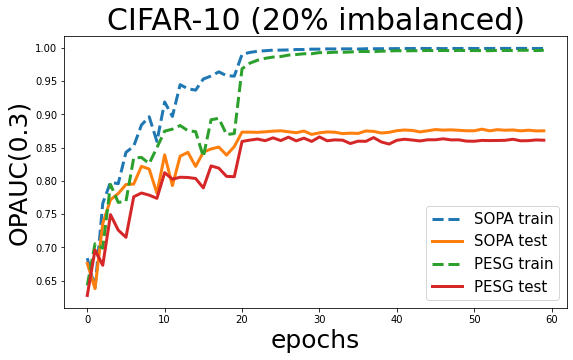

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(60)
aucm_tr_pAUC = [0.6429585593723751, 0.705619972966429, 0.69894917006115, 0.7947875283260033, 0.7677915794870532, 0.7694341408326258, 0.8345354696048994, 0.8353778185042913, 0.8261352422411384, 0.850143596501959, 0.8749833709434203, 0.8778469862659533, 0.8833579163047021, 0.8755243973017512, 0.874157483715067, 0.8366073362501383, 0.8920074624226216, 0.8941630657880417, 0.8697558150194012, 0.8712549503124775, 0.9686330493047073, 0.9769933546518772, 0.9815388471447516, 0.9843683141845079, 0.9862415423489106, 0.9870076275453813, 0.9891961884708532, 0.9900528747015318, 0.9912304734205963, 0.9912435867529628, 0.9929736720264557, 0.9928194070381502, 0.9935700668345326, 0.9933461158425558, 0.9939052576360476, 0.9946626137958484, 0.9945831000132086, 0.9943817922164405, 0.9950893414460829, 0.9952917756106698, 0.9958267789776483, 0.9955192943758522, 0.9957648139930699, 0.9957864767962223, 0.9961289076816299, 0.99591124055382, 0.9961174449741217, 0.9958902131376424, 0.996271318496243, 0.9960302217876651, 0.9959968608322265, 0.995976135413218, 0.9958279797460171, 0.9962699055136474, 0.9961840783577622, 0.996047774666769, 0.9964594341651255, 0.9964745506616648, 0.9960480697575578, 0.996416429077646]
aucm_te_pAUC = [0.6279169411764706, 0.696358431372549, 0.673276862745098, 0.7493461960784313, 0.7261282745098039, 0.7153201960784313, 0.7762015294117646, 0.781920274509804, 0.778698862745098, 0.773890431372549, 0.8124459607843137, 0.802709294117647, 0.8055946274509804, 0.8052427843137255, 0.8037347843137256, 0.789566862745098, 0.8226527450980392, 0.819271725490196, 0.8068901176470589, 0.8064509019607844, 0.8594197647058823, 0.8614054901960784, 0.8630056862745098, 0.8605498823529412, 0.8648399607843138, 0.8607361176470588, 0.8658290196078431, 0.8603041176470588, 0.8643641960784314, 0.8594430588235293, 0.8661986274509804, 0.8604558823529411, 0.8617808235294118, 0.8613043529411765, 0.8562662352941177, 0.859865137254902, 0.8595644705882353, 0.865197294117647, 0.858666862745098, 0.8554585490196078, 0.8611540392156862, 0.8627088627450981, 0.8615218823529411, 0.8601713725490197, 0.8619247450980392, 0.8619268627450981, 0.8633670196078431, 0.8617367058823528, 0.8618482352941177, 0.859918, 0.8597246666666667, 0.860948705882353, 0.8607091372549018, 0.8608580784313726, 0.8610979215686274, 0.8626889803921569, 0.8603958039215687, 0.8605810980392157, 0.8616598039215686, 0.8612713725490196]
plt.figure()
plt.plot(x, tr_pAUC, LineStyle='--', label='SOPA train', linewidth=3)
plt.plot(x, te_pAUC, label='SOPA test', linewidth=3)
plt.plot(x, aucm_tr_pAUC, LineStyle='--', label='PESG train', linewidth=3)
plt.plot(x, aucm_te_pAUC, label='PESG test', linewidth=3)
plt.title('CIFAR-10 (20% imbalanced)',fontsize=30)
plt.legend(fontsize=15)
plt.ylabel('OPAUC(0.3)',fontsize=25)
plt.xlabel('epochs',fontsize=25)